# Scotland’s Monthly Birth-Rate Forecasting

## Import Libraries

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [398]:
df = pd.read_excel('dataset.xlsx')
df.head()

,Table 1: Monthly birth registrations in Scotland by NHS Board area [note 1][note 2][note 3][note 4][note 6],Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Births by month of registration and NHS Board ...,NaN,NaN,NaN
1,This worksheet contains one table.,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Year,Month,NHS Board area,Births registered
4,2025,June,Ayrshire and Arran,273


## Data Preprocessing

In [399]:
df.columns = ['Year', 'Month', 'NHS_Board', 'Births']

In [400]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  

df_filtered = df[(df['Year'] >= 1998) & (df['Year'] <= 2022)]

In [401]:
df_scotland = df_filtered[df_filtered['NHS_Board'] == 'Scotland']

In [402]:
df_scotland.reset_index(drop=True, inplace=True)

In [403]:
df_scotland.info()
df_scotland.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       300 non-null    float64
 1   Month      300 non-null    object 
 2   NHS_Board  300 non-null    object 
 3   Births     300 non-null    object 
dtypes: float64(1), object(3)
memory usage: 9.5+ KB


,Year
count,300.000000
mean,2010.000000
std,7.223151
min,1998.000000
25%,2004.000000
50%,2010.000000
75%,2016.000000
max,2022.000000


In [404]:
df_scotland.isnull().sum()

Year         0
Month        0
NHS_Board    0
Births       0
dtype: int64

In [405]:
df_scotland['Year'] = df_scotland['Year'].astype(int)

df_scotland['Date'] = pd.to_datetime(df_scotland['Month'] + ' ' + df_scotland['Year'].astype(str), format='%B %Y')

In [406]:
df_scotland['Births'] = df_scotland['Births'].astype(int)

In [407]:
df = df_scotland.copy()

## Exploratory Data Analysis

**Full Monthly Birth Trend (1998–2022)**

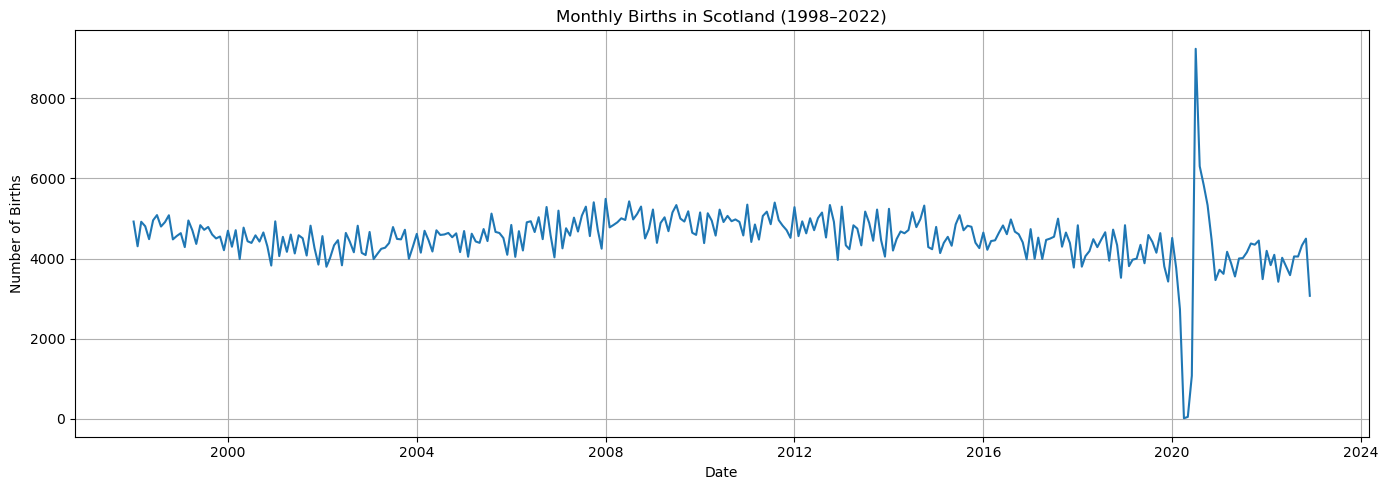

In [408]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='Date', y='Births')
plt.title("Monthly Births in Scotland (1998–2022)")
plt.xlabel("Date")
plt.ylabel("Number of Births")
plt.grid(True)
plt.tight_layout()
plt.show()

**Seasonality – Average Monthly Births Across Years**

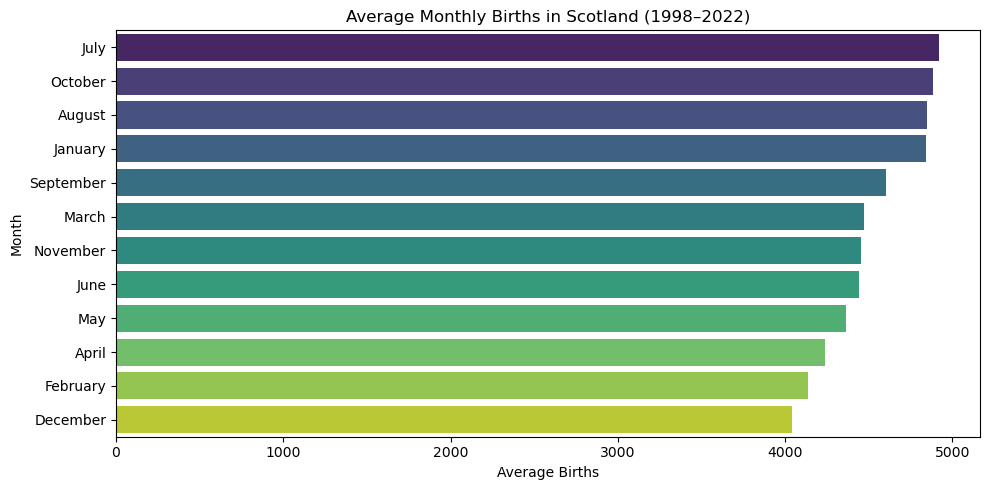

In [409]:
# Calculate average births per month
monthly_avg = df.groupby('Month')['Births'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'])

monthly_avg_sorted = monthly_avg.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(y=monthly_avg_sorted.index, x=monthly_avg_sorted.values, palette='viridis', orient='h')
plt.title("Average Monthly Births in Scotland (1998–2022)")
plt.xlabel("Average Births")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

**Add Date-Based Features**

In [410]:
df = df.sort_values('Date').set_index('Date')

In [411]:
df['Month_Num'] = df.index.month
df['Quarter'] = df.index.quarter

# Step 1: Log transform the target
df['Births'] = np.log1p(df['Births'])  # log(1 + births)

# Step 2: Create lag features on the transformed series
df['Births_lag1'] = df['Births'].shift(1)
df['Births_lag12'] = df['Births'].shift(12)

## Basline Models

In [412]:
# SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Plotting helper
import matplotlib.pyplot as plt

def plot_forecast(y_train, y_test, y_pred, title='Forecast'):
    plt.figure(figsize=(12, 6))
    
    # Build timeline
    all_index = list(y_train.index) + list(y_test.index)
    
    # Plot
    plt.plot(y_train.index, y_train, label='Train', color='blue')
    plt.plot(y_test.index, y_test, label='Test', color='green')
    plt.plot(y_test.index, y_pred, label='Forecast', color='orange')
    
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Monthly Births')
    plt.legend()
    plt.tight_layout()
    plt.show()



# Evaluation helper
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    s = smape(y_true, y_pred)
    print(f"\n{model_name} Results")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, SMAPE: {s:.2f}%")
    return mae, rmse, s

**Train test Split**

In [413]:
# Split by date
train = df['1998':'2018']
val = df['2019':'2020']
test = df['2021':'2022']

print(f"Train size: {len(train)}, Val size: {len(val)}, Test size: {len(test)}")

# Ensure log column
df['log_births'] = np.log(df['Births'])

Train size: 252, Val size: 24, Test size: 24


### SARIMA Model

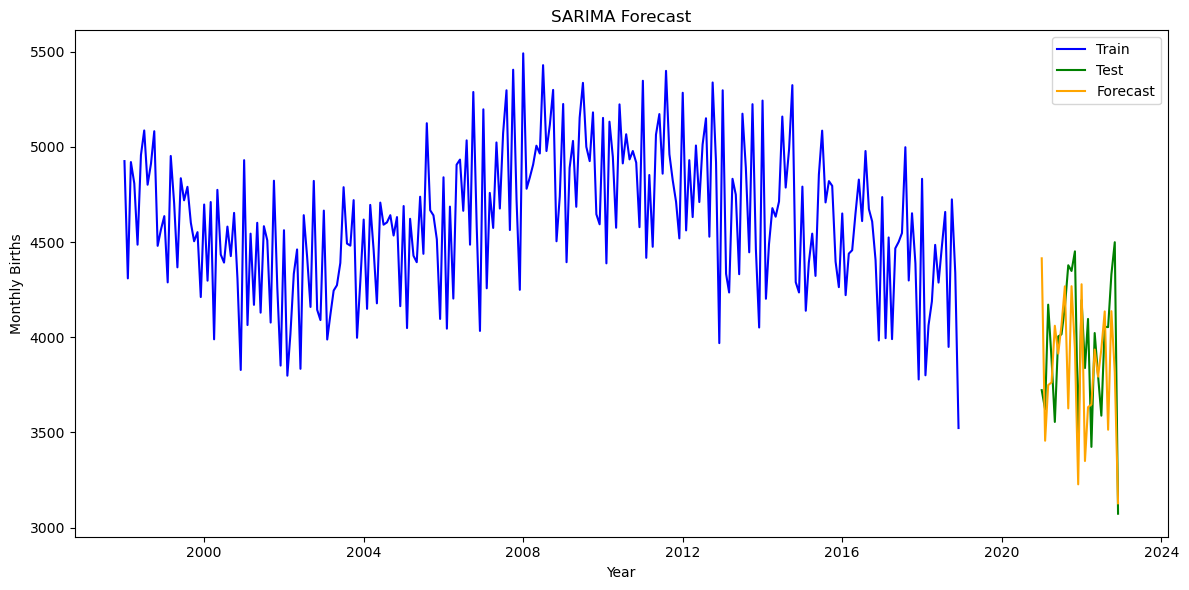

                                      SARIMAX Results                                      
Dep. Variable:                              Births   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 349.079
Date:                             Thu, 31 Jul 2025   AIC                           -690.158
Time:                                     21:21:50   BIC                           -676.476
Sample:                                 01-01-1998   HQIC                          -684.637
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3285      0.070     -4.673      0.000      -0.466      -0.191
ma.L1         -0.8699      

(292.20755950786724,
 np.float64(372.3177038380116),
 np.float64(7.500644634617287))

In [414]:
sarima_model = sm.tsa.SARIMAX(train['Births'], order=(1,1,1), seasonal_order=(1,1,0,12), 
                              enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()

sarima_forecast_log = sarima_results.predict(start=test.index[0], end=test.index[-1], dynamic=False)
sarima_forecast = np.exp(sarima_forecast_log)

plot_forecast(np.exp(train['Births']), np.exp(test['Births']), sarima_forecast, 'SARIMA Forecast')
print(sarima_results.summary())
evaluate(np.exp(test['Births']), sarima_forecast, "SARIMA")


### ARIMA Model

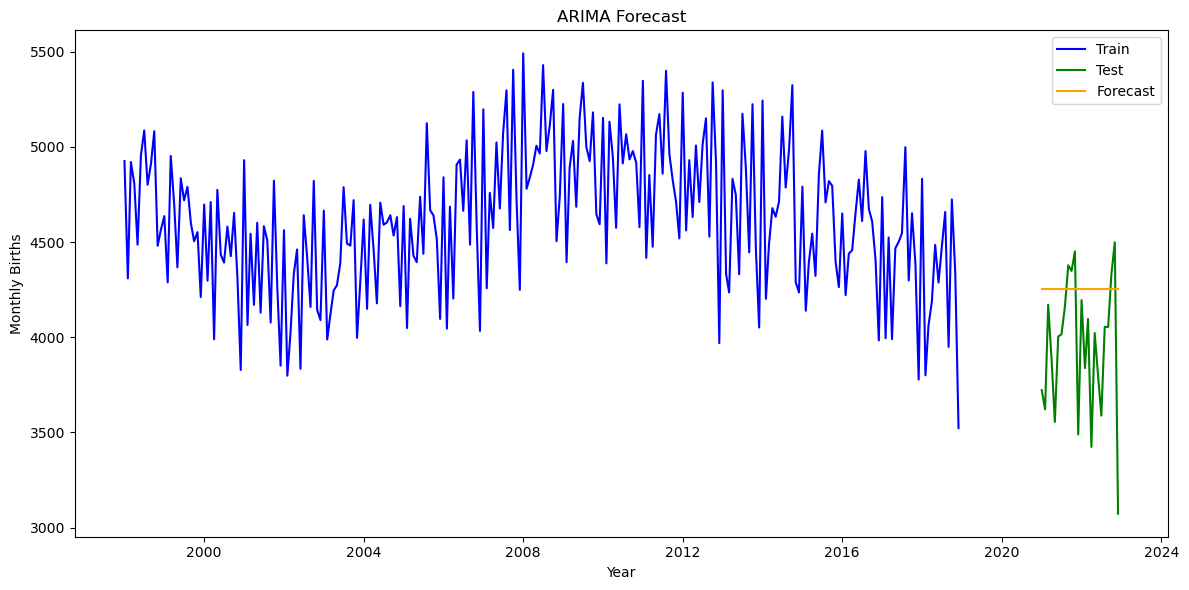

                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 310.431
Date:                Thu, 31 Jul 2025   AIC                           -614.862
Time:                        21:21:52   BIC                           -604.286
Sample:                    01-01-1998   HQIC                          -610.606
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2900      0.070     -4.161      0.000      -0.427      -0.153
ma.L1         -0.8460      0.038    -22.145      0.000      -0.921      -0.771
sigma2         0.0049      0.000     10.931      0.0

(367.44722731714745,
 np.float64(467.67331781307274),
 np.float64(9.27050584683352))

In [415]:
arima_model = sm.tsa.ARIMA(train['Births'], order=(1, 1, 1))
arima_results = arima_model.fit()

arima_forecast_log = arima_results.predict(start=test.index[0], end=test.index[-1], dynamic=False)
arima_forecast = np.exp(arima_forecast_log)

plot_forecast(np.exp(train['Births']), np.exp(test['Births']), arima_forecast, 'ARIMA Forecast')
print(arima_results.summary())
evaluate(np.exp(test['Births']), arima_forecast, "ARIMA")


### XgBoost Model

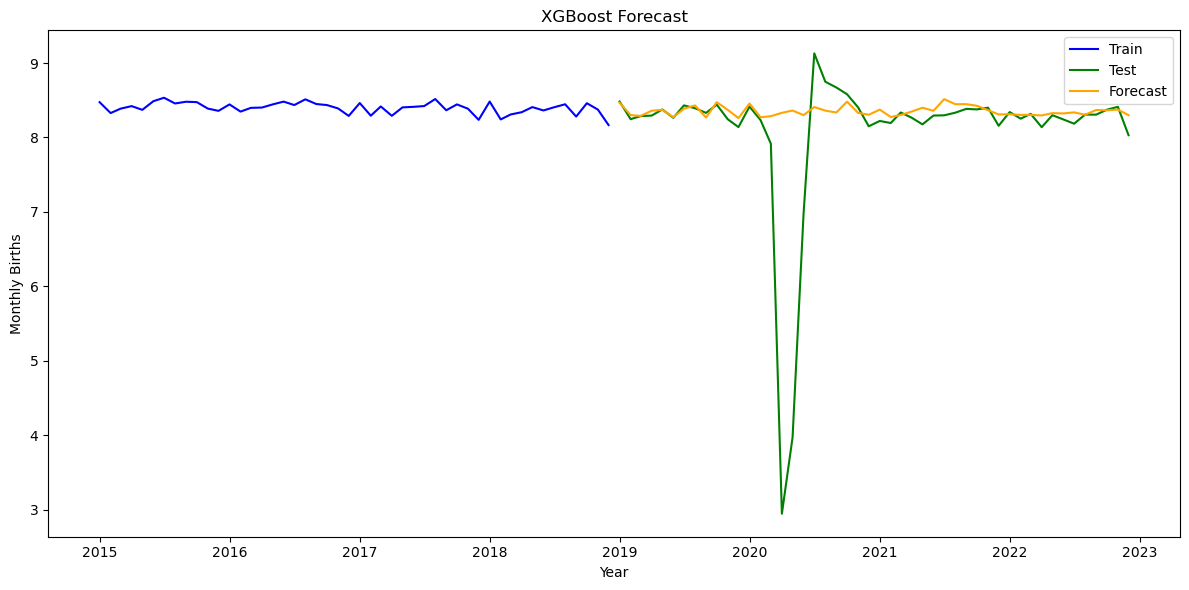

XGBoost - MAE: 0.33, RMSE: 1.03, SMAPE: 5.07


In [416]:
def create_lag_features(df, lags=12):
    df_lagged = pd.DataFrame()
    df_lagged['target'] = df['log_births']
    for lag in range(1, lags + 1):
        df_lagged[f'lag_{lag}'] = df['log_births'].shift(lag)
    return df_lagged.dropna()

lagged_df = create_lag_features(df, lags=12)

# --- 2. Align With Original Index ---
lagged_df.index = df.index[12:]  # Align lagged index with original date index

# --- 3. Split into Train/Test ---
n_train = len(train)
train_lagged = lagged_df.iloc[:n_train - 12]  # exclude initial 12 NaNs
test_lagged = lagged_df.iloc[n_train - 12:]   # remaining as test

X_train = train_lagged.drop('target', axis=1)
y_train = train_lagged['target']
X_test = test_lagged.drop('target', axis=1)
y_test = test_lagged['target']

# --- 4. Fit XGBoost Model ---
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- 5. Predict and Inverse Log ---
y_pred_log = xgb_model.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_actual = np.exp(y_test)
y_train_recent = np.exp(y_train.iloc[-len(y_test):])

# --- 6. For Plotting: Get Recent Train (Same Length as Test) ---
recent_train_log = y_train.iloc[-len(y_test):]
recent_train = np.exp(recent_train_log)

# --- 7. Plot Forecast ---
plot_forecast(
    y_train=y_train_recent,     # already np.exp(...)
    y_test=y_test_actual,       # already np.exp(...)
    y_pred=y_pred,              # already np.exp(...)
    title='XGBoost Forecast'
)



# --- 8. Evaluate Metrics ---
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, SMAPE: {smape:.2f}")
    return mae, rmse, smape

xgb_mae, xgb_rmse, xgb_smape = evaluate(y_test_actual, y_pred, "XGBoost")

In [418]:
results_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'SMAPE'])

for model_name, y_true, y_pred in [
    ('SARIMA', np.exp(test['Births']), sarima_forecast),
    ('ARIMA', np.exp(test['Births']), arima_forecast),
    ('XGBoost', y_test_actual, y_pred)]:
    mae, rmse, smape_val = evaluate(y_true, y_pred, model_name)
    results_df.loc[len(results_df)] = [model_name, mae, rmse, smape_val]

print(results_df)

SARIMA - MAE: 292.21, RMSE: 372.32, SMAPE: 7.50
ARIMA - MAE: 367.45, RMSE: 467.67, SMAPE: 9.27
XGBoost - MAE: 0.33, RMSE: 1.03, SMAPE: 5.07
     Model         MAE        RMSE     SMAPE
0   SARIMA  292.207560  372.317704  7.500645
1    ARIMA  367.447227  467.673318  9.270506
2  XGBoost    0.334454    1.034545  5.065344
